In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import nltk
import re
import string
import sys

from google.colab import drive
drive.mount('/content/drive')

#All relevant files and modules were uploaded to a Google Drive directory
sys.path.append('[Drive Directory]']

Mounted at /content/drive


## Data Import

In [ ]:
#Import files built during data cleaning/preprocessing
words20k = np.load('drive/words20k.npy') #File paths should be altered here based on layout of user's drive
glove100 = np.load('drive/embedding100.npy')
ft300 = np.load('drive/fasttext300.npy')
c_golbeck = pd.read_csv('drive/c_golbeck.csv')
c_blodgett = pd.read_csv('drive/c_blodgett.csv')

## Word Embedding Visualization

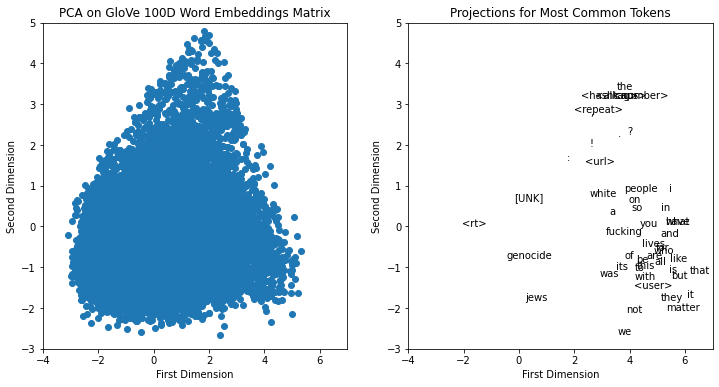

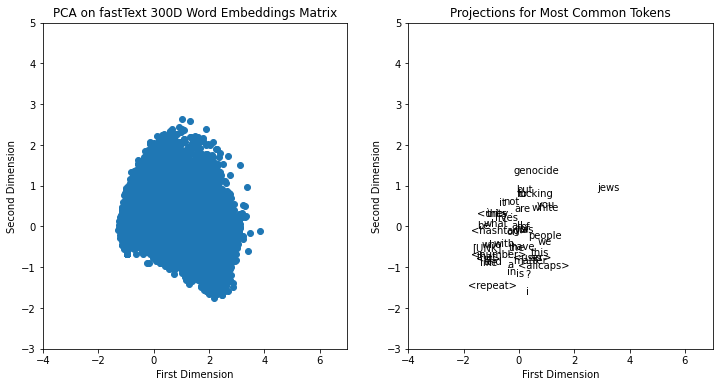

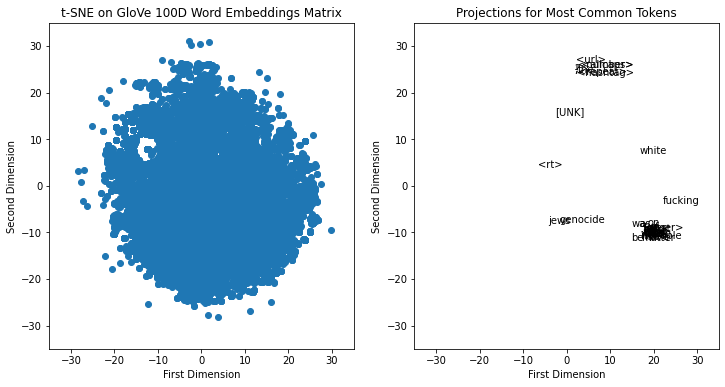

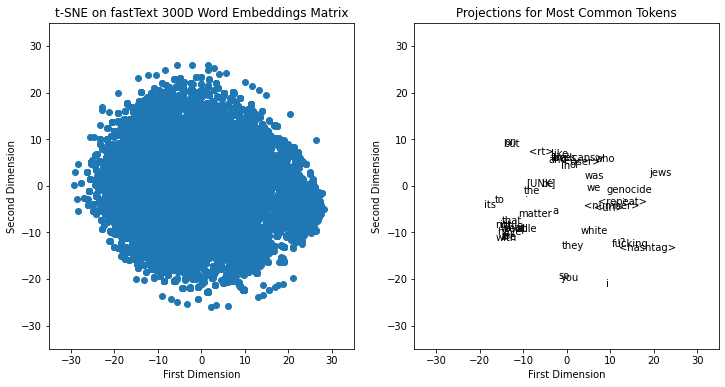

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_embeddings(embed, dim_red='PCA'):
  '''
  Dimension reduction plotter for GloVe 100D and fastText 300D embeddings
  Function supports PCA and t-SNE (can be altered to add others)
  '''
  if dim_red not in ['PCA','t-SNE']:
    raise ValueError('Dimension reduction must be either "PCA" or "t-SNE"')
  if dim_red == 'PCA':
    reduction = PCA(n_components=2)
  else:
    reduction = TSNE(n_components=2, init='pca', random_state=0, n_iter=500)

  title = 'GloVe 100D' if embed.shape[1] == 100 else 'fastText 300D'
  
  embedding_reduced = reduction.fit_transform(embed)

  fig, axes = plt.subplots(1, 2, figsize=(12,6))
  axes[0].scatter(embedding_reduced[:,0], embedding_reduced[:,1])
  if dim_red == 'PCA':
    plt.setp(axes, xlim=(-4,7), ylim=(-3,5), xlabel='First Dimension', ylabel='Second Dimension')
  else:
    plt.setp(axes, xlim=(-35,35), ylim=(-35,35), xlabel='First Dimension', ylabel='Second Dimension')
  [axes[1].text(embedding_reduced[i,0]+np.random.uniform(-1,1), embedding_reduced[i,1]+np.random.uniform(-1,1), \
                words20k[i]) for i in range(50)]
  axes[0].set_title('{} on {} Word Embeddings Matrix'.format(dim_red, title))
  axes[1].set_title('Projections for Most Common Tokens');

  return None

np.random.seed(1)
plot_embeddings(glove100, dim_red='PCA')
plot_embeddings(ft300, dim_red='PCA')
plot_embeddings(glove100, dim_red='t-SNE')
plot_embeddings(ft300, dim_red='t-SNE')

## Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

tweets = c_golbeck['clean_tweet']
tokens = c_golbeck['tokens']

#*****Encoded such that 1 = Harassing tweet; 0 = Non-harassing tweet*****
labels = pd.get_dummies(c_golbeck['Code'])['H']
#Create 85% training set and 15% test set
tweet_train, tweet_test, label_train, label_test = train_test_split(tweets, labels, stratify=labels, 
                                                                    test_size=0.15, random_state=449)

#Save initial train/test split indexes for the Logistic Regression model
train_ind, test_ind = tweet_train.index, tweet_test.index

#Break up 85% training set further into a training set and a validation set for neural language models
tweet_train, tweet_val, label_train, label_val = train_test_split(tweet_train, label_train, stratify=label_train,
                                                                  test_size=0.15, random_state=449)

## Logistic Regression Model Training and Validation

In [ ]:
#Setting up Pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')

#Use 5-fold CV to perform Grid Search over number of features to consider
parameters = {'vect__max_features':[100, 500, 1000, 2000, 5000]}
scoring = {'accuracy':'accuracy', 'precision':'precision', 'recall':'recall',
           'f1':'f1', 'weighted_f1':'f1_weighted'}

#Test sensitivity of results to both bag-of-words and tf-idf vectorization approaches
lr_bow = Pipeline([
  ('vect', CountVectorizer(stop_words=stop)),
  ('clf', LogisticRegression('l2', max_iter=500)),
])

lr_tfidf = Pipeline([
  ('vect', TfidfVectorizer(stop_words=stop)),
  ('clf', LogisticRegression('l2', max_iter=500)),           
])

#Will fit the best LR model as determined by weighted F1 score across the 5 folds
gs_bow = GridSearchCV(lr_bow, parameters, cv=5, n_jobs=-1, scoring=scoring, refit='weighted_f1')
gs_tfidf = GridSearchCV(lr_tfidf, parameters, cv=5, n_jobs=-1, scoring=scoring, refit='weighted_f1')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
gs_bow.fit(tokens.iloc[train_ind], labels[train_ind])
gs_tfidf.fit(tokens.iloc[train_ind], labels[train_ind])

print('CV Average Weighted F1 scores for 100, 500, 1000, 2000, and 5000 features:')
print('Bag of Words: ',np.round(gs_bow.cv_results_['mean_test_weighted_f1'], 4))
print('Tf-idf: ',np.round(gs_tfidf.cv_results_['mean_test_weighted_f1'],4))
print('\nBest model by weighted F1 is BOW with 2000 features')

CV Average Weighted F1 scores for 100, 500, 1000, 2000, and 5000 features:
Bag of Words:  [0.7054 0.716  0.7154 0.7202 0.7201]
Tf-idf:  [0.6963 0.7068 0.7103 0.7132 0.7119]

Best model by weighted F1 is BOW with 2000 features


## Neural Language Model Construction

In [ ]:
#Re-build same vectorizer used to transform Golbeck data
from keras.layers.experimental.preprocessing import TextVectorization
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=60, standardize=None)
vectorizer.adapt(tf.data.Dataset.from_tensor_slices(c_golbeck['clean_tweet']).batch(128))

In [ ]:
#Set up data to be fed into embedding layer in NNs
X_train = vectorizer(np.array([[tweet] for tweet in tweet_train])).numpy()
X_val = vectorizer(np.array([[tweet] for tweet in tweet_val])).numpy()
y_train = np.array(label_train).reshape((-1,1))
y_val = np.array(label_val).reshape((-1,1))
X_test = vectorizer(np.array([[tweet] for tweet in tweet_test])).numpy()
y_test = np.array(label_test).reshape((-1,1))

In [ ]:
from keras.regularizers import l2
from keras import layers
from keras.layers import Embedding

In [ ]:
# Embedding Layer (distinct for both GloVe and fastText)

embedding_glove_100 = Embedding(
    len(vectorizer.get_vocabulary()),
    100, 
    embeddings_initializer=keras.initializers.Constant(glove100),
    trainable=False
)

embedding_ft_300 = Embedding(
    len(vectorizer.get_vocabulary()),
    300, 
    embeddings_initializer=keras.initializers.Constant(ft300),
    trainable=False
)

In [ ]:
#Neural Language Model 1: Simple Recurrent Neural Network

def build_rnn(embedding, name):
  model_rnn = keras.Sequential(name=name)
  model_rnn.add(embedding)
  model_rnn.add(layers.SimpleRNN(128, activation='relu'))
  model_rnn.add(layers.Dense(1, activation='sigmoid'))
  model_rnn.summary()
  return model_rnn

model_rnn_glove = build_rnn(embedding_glove_100, 'RNN_GloVe')
model_rnn_ft = build_rnn(embedding_ft_300, 'RNN_fastText')

Model: "RNN_GloVe"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               29312     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,029,441
Trainable params: 29,441
Non-trainable params: 2,000,000
_________________________________________________________________
Model: "RNN_fastText"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         6000000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               54912     
____________________

In [ ]:
#Neural Language Model 2: Gated Recurrent Unit 

def build_gru(embedding, name):
  model_gru = keras.Sequential(name=name)
  model_gru.add(embedding)
  #Output dimension is (batch_size, timestep, units)
  model_gru.add(layers.GRU(256, activation='tanh', return_sequences=True))
  #Global Pooling takes max around time dimension, reducing to (batch_size, units)
  model_gru.add(layers.GlobalMaxPooling1D())
  model_gru.add(layers.Dense(1, activation='sigmoid'))
  model_gru.summary()
  return model_gru

model_gru_glove = build_gru(embedding_glove_100, 'GRU_GloVe')
model_gru_ft = build_gru(embedding_ft_300, 'GRU_fastText')

Model: "GRU_GloVe"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
gru (GRU)                    (None, None, 256)         274944    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,275,201
Trainable params: 275,201
Non-trainable params: 2,000,000
_________________________________________________________________
Model: "GRU_fastText"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         6000000   
___________________

In [ ]:
#Attention Layer created by Chakrabarty et al. (2019) with minor tweaks by me
from Attention import Attention

In [ ]:
#Neural Language Model 3: Stacked Bi-directional GRU with Self-Attention

def build_att(embedding, name):
  dim = embedding.output_dim
  model_att = keras.Sequential(name=name)
  model_att.add(keras.Input(shape=(60,), dtype='float64'))
  model_att.add(embedding)
  model_att.add(layers.Dropout(0.25))
  model_att.add(layers.Bidirectional(layers.GRU(dim//2, return_sequences=True)))
  model_att.add(layers.Dropout(0.25))
  model_att.add(layers.Bidirectional(layers.GRU(dim//2, return_sequences=True)))
  model_att.add(layers.Dropout(0.25))
  model_att.add(Attention())
  model_att.add(layers.Dense(100, activation='relu'))
  model_att.add(layers.Dropout(0.25))
  model_att.add(layers.Dense(1,activity_regularizer=l2(0.0001), activation='sigmoid'))
  model_att.summary()
  return model_att

model_att_glove = build_att(embedding_glove_100, 'Attention_GloVe')
model_att_ft = build_att(embedding_ft_300, 'Attention_fastText')

Model: "Attention_GloVe"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  2000000   
_________________________________________________________________
dropout (Dropout)            (None, 60, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 100)           45600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 100)           45600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
attention (Attention)        (None, 100)           

In [ ]:
#Set class weights due to unbalanced labels in the dataset
from sklearn.utils import compute_class_weight
classWeight = compute_class_weight('balanced', [0,1], label_train) 
classWeight = dict(enumerate(classWeight))
classWeight

{0: 0.67047385312441, 1: 1.966500553709856}

## Neural Language Model Training and Validation

In [ ]:
learning_rate = 0.001
batch_size=64
checkpoint_filepath = '/tmp/checkpoint'

def train_NN(model, epochs=25):
  opt = keras.optimizers.Adam(learning_rate)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics='accuracy')  

#Will reload model weights corresponding to model with highest validation accuracy at end of an epoch
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
  save_best_only=True)

  print('\nTraining model...')
  history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, \
            validation_data = (X_val, y_val), verbose = 1, \
            class_weight=classWeight, callbacks=[model_checkpoint_callback])
  return history

#Fit each of 3 models separately for GloVe and fastText embeddings
history1 = train_NN(model_rnn_glove, epochs=5) #Only 5 epochs because only learns majority class labels
model_rnn_glove.load_weights(checkpoint_filepath)

history2 = train_NN(model_rnn_ft, epochs=5)
model_rnn_ft.load_weights(checkpoint_filepath)

history3 = train_NN(model_gru_glove)
model_gru_glove.load_weights(checkpoint_filepath)

history4 = train_NN(model_gru_ft)
model_gru_ft.load_weights(checkpoint_filepath)

history5 = train_NN(model_att_glove)
model_att_glove.load_weights(checkpoint_filepath)

history6 = train_NN(model_att_ft)
model_att_ft.load_weights(checkpoint_filepath)


Training model...
Epoch 1/5
222/222 [==============================] - 9s 37ms/step - loss: 0.6892 - accuracy: 0.6254 - val_loss: 0.6944 - val_accuracy: 0.2544
Epoch 2/5
222/222 [==============================] - 8s 37ms/step - loss: 0.6966 - accuracy: 0.4081 - val_loss: 0.6931 - val_accuracy: 0.7452
Epoch 3/5
222/222 [==============================] - 8s 37ms/step - loss: 0.6922 - accuracy: 0.7353 - val_loss: 0.6933 - val_accuracy: 0.7452
Epoch 4/5
222/222 [==============================] - 9s 39ms/step - loss: 0.6916 - accuracy: 0.6970 - val_loss: 0.6924 - val_accuracy: 0.7452
Epoch 5/5
222/222 [==============================] - 9s 39ms/step - loss: 0.6962 - accuracy: 0.3755 - val_loss: 0.6923 - val_accuracy: 0.7452

Training model...
Epoch 1/5
222/222 [==============================] - 10s 42ms/step - loss: 0.6976 - accuracy: 0.2870 - val_loss: 0.6904 - val_accuracy: 0.7452
Epoch 2/5
222/222 [==============================] - 9s 41ms/step - loss: 0.6922 - accuracy: 0.7101 - val_los

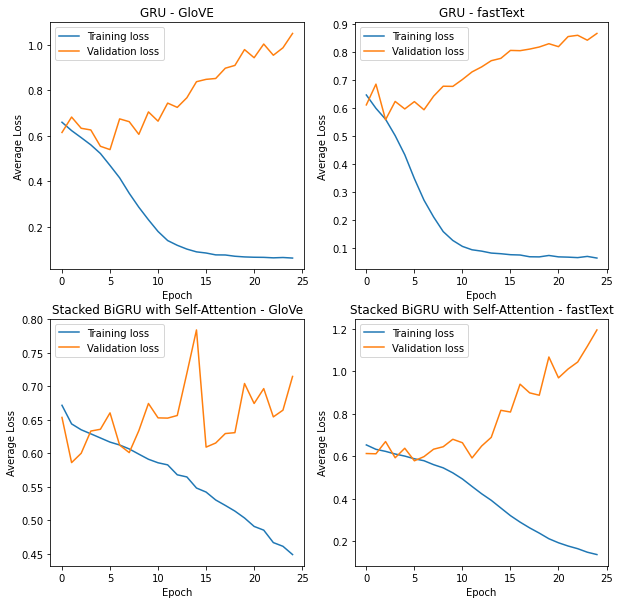

In [ ]:
#Plot Loss Curves
subtitles = ['GRU - GloVE', 'GRU - fastText', 'Stacked BiGRU with Self-Attention - GloVe', 'Stacked BiGRU with Self-Attention - fastText']
histories = list([history3, history4, history5, history6])
fig, axes = plt.subplots(2, 2, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    ax.plot(histories[i].history['loss'], label='Training loss')
    ax.plot(histories[i].history['val_loss'], label='Validation loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average Loss')
    ax.set_title(subtitles[i])
    ax.legend()
fig.savefig('loss_plots.pdf', bbox_inches='tight')

## Model Evaluation on Test Set

In [ ]:
#Compute neural language model evaluation metrics on test set

from sklearn.metrics import precision_score, recall_score, f1_score

def class_metrics(model):
  y_pred = model.predict_classes(X_test)
  metrics = {}
  metrics['_model'] = model.name
  metrics['accuracy'] = np.mean(y_pred == y_test)
  metrics['precision'] = precision_score(y_test, y_pred)
  metrics['recall'] = recall_score(y_test, y_pred)
  metrics['f1'] = f1_score(y_test, y_pred)
  metrics['weighted_f1'] = f1_score(y_test, y_pred, average='weighted')
  return metrics

model_metrics = list(map(class_metrics, [model_rnn_glove, model_rnn_ft, model_gru_glove, model_gru_ft, model_att_glove, model_att_ft]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Combine all models' test set results together into a df
from sklearn.metrics import precision_score, recall_score, f1_score
y_test = labels[test_ind]
y_pred = gs_bow.predict(tokens[test_ind])
lr_metrics = {'_model':'LR_BOW', 'accuracy': np.mean(y_pred == y_test),
           'precision': precision_score(y_test, y_pred), 'recall': recall_score(y_test, y_pred),
           'f1': f1_score(y_test, y_pred), 'weighted_f1': f1_score(y_test, y_pred, average='weighted')}

pd.DataFrame(model_metrics).append(lr_metrics, ignore_index=True)

,_model,accuracy,precision,recall,f1,weighted_f1
0,RNN_GloVe,0.745763,0.000000,0.000000,0.000000,0.637156
1,RNN_fastText,0.745763,0.000000,0.000000,0.000000,0.637156
2,GRU_GloVe,0.760339,0.547461,0.330667,0.412303,0.738332
3,GRU_fastText,0.740000,0.482255,0.308000,0.375915,0.718877
4,Attention_GloVe,0.703729,0.417989,0.421333,0.419655,0.704117
5,Attention_fastText,0.755254,0.527668,0.356000,0.425159,0.737911
6,LR_BOW,0.762034,0.570588,0.258667,0.355963,0.727421


## Evaluation on Blodgett Dataset

### Apply same pre-processing steps that were used for Golbeck data

In [ ]:
#Python version of Ruby preprocessing script accessible here: https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb
from preprocessTwitter import tokenize 

def clean_tweets(tweet):
    '''
    This function applies additional cleaning steps to the tweets 
    in order for the word embeddings to capture more semantic/syntactic information
    '''
    tweet = re.sub('^RT:? ','<rt> ',tweet) #Assign special char to RTs
    tweet = re.sub('RT@','<rt> @',tweet) #Split out RT and user mention when overlapping
    tweet = re.sub('via@','via @',tweet) #Split out 'via' and user mention when overlapping
    tweet = re.sub(r'https?: ?/ ?/t(.co( )?)?/?[A-Za-z0-9é]*|https?:\\/\\/t.co\\/[A-Za-z0-9]*é?|https?(: / /)?é?', '<url>', tweet) #Assign special char to URLs (Python script missing some cases that I do not)
    tweet = re.sub(r'<url>é|<url> ?\.c[oé]*$', '<url>', tweet, flags=re.IGNORECASE) 
    tweet = re.sub(r"'", '', re.sub(r'"', '', tweet)) #Get rid of single and double quotes (admittedly loses some context here)
    tweet = re.sub('anti-', 'anti ', tweet, flags=re.IGNORECASE) #Capture 'anti' or 'non' prefix as its own word 
    tweet = re.sub('#anti', '#anti ', tweet, flags=re.IGNORECASE)
    tweet = re.sub(' anti', ' anti ', tweet, flags=re.IGNORECASE)
    tweet = re.sub('non-', 'non ', tweet, flags=re.IGNORECASE)
    tweet = re.sub('&amp;?', '&', tweet, flags=re.IGNORECASE) #Put ampersand in recognizable format
    #Clean some known hateful terms that are in the data (e.g. "whitepower") to extract meaning from hashtags
    tweet = re.sub('#white', '#white ', tweet, flags=re.IGNORECASE)
    tweet = re.sub('waronwhite', 'war on white', tweet, flags=re.IGNORECASE)
    tweet = re.sub('whitegenocide', 'white genocide', tweet, flags = re.IGNORECASE)
    tweet = re.sub('whitelivesmatter', 'white lives matter', tweet, flags = re.IGNORECASE)
    tweet = re.sub('blacklivesmatter', 'black lives matter', tweet, flags = re.IGNORECASE)
    tweet = re.sub('livesmatter', 'lives matter', tweet, flags = re.IGNORECASE)
    tweet = re.sub('alllive', 'all live', tweet, flags = re.IGNORECASE)
    tweet = re.sub('bluelive', 'blue live', tweet, flags = re.IGNORECASE)
    tweet = re.sub('whitepower', 'white power', tweet, flags = re.IGNORECASE)
    tweet = re.sub('#fuck', '#fuck ', tweet, flags=re.IGNORECASE)
    tweet = re.sub('fuckniggers', 'fuck niggers', tweet, flags=re.IGNORECASE)
    tweet = re.sub('sjw', 'social justice warrior', tweet, flags=re.IGNORECASE)
    tweet = tweet.strip() #Strip whitespace
    return tweet

In [ ]:
#Apply same cleaning steps as were applied to Golbeck data
c_blodgett['clean_tweet'] = c_blodgett['tweet'].apply(clean_tweets)
c_blodgett['clean_tweet'] = c_blodgett['clean_tweet'].apply(tokenize)
c_blodgett['clean_tweet'] = c_blodgett['clean_tweet'].apply(lambda x:re.sub('><', '> <', x))
c_blodgett.head()

,Unnamed: 0,ID,tweet,AAE,clean_tweet
0,1,342411683622449152,"""\""@ceoofreadient: Damn they fucked around n l...",1,\<user> : damn they fucked around n locked up ...
1,2,372875081338589184,"""Chillin thou""",1,chillin thou
2,3,304393706839101440,"""I love all my mac's even the ones i aint meet...",1,i love all my macs even the ones i aint meet y...
3,4,326166862897487872,"""My mom should really stop!""",1,my mom should really stop !
4,5,338709396735537152,"""Lemme change that 0.o""",1,lemme change that <number>o


In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=60, standardize=None)
tweets = tf.data.Dataset.from_tensor_slices(c_golbeck['clean_tweet']).batch(128)
vectorizer.adapt(tweets)
#Input Blodgett data into this vectorizer
X_new = vectorizer(np.array([[tweet] for tweet in c_blodgett['clean_tweet']])).numpy()

In [ ]:
#Predictions for top 3 models (exclude simple RNN)
LR_preds = gs_bow.predict(c_blodgett['clean_tweet'])

def predict_nn(model):
  preds = model.predict_classes(X_new)
  return [i[0] for i in preds]

GRU_glove_preds = predict_nn(model_gru_glove)
GRU_ft_preds = predict_nn(model_gru_ft)
Att_glove_preds = predict_nn(model_att_glove)
Att_ft_preds = predict_nn(model_att_ft)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
#Plot breakdown of prediction frequencies
plot_data = pd.DataFrame(np.transpose(np.array([LR_preds, GRU_glove_preds, GRU_ft_preds, Att_glove_preds, Att_ft_preds])))
plot_data.rename(columns={0:'LR', 1:'GRU_glove', 2:'GRU_ft', 3:'Att_Glove', 4:'Att_ft'}, inplace=True)
plot_data['AAE'] = c_blodgett['AAE']

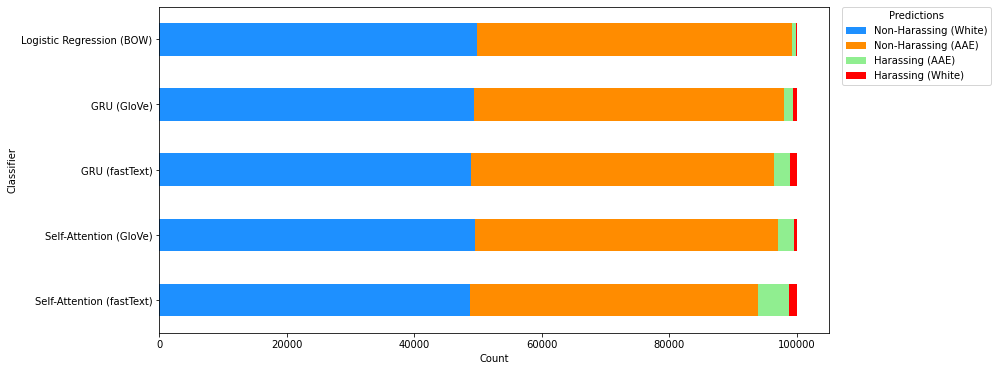

In [ ]:
plot_data2 = pd.melt(plot_data, id_vars = 'AAE', value_vars = ['LR','GRU_glove','GRU_ft','Att_Glove','Att_ft'])
plot_data2 = pd.DataFrame(plot_data2.value_counts(sort=False))[0].unstack(['value','AAE'])
models = ['Self-Attention (fastText)', 'Self-Attention (GloVe)', 'GRU (fastText)', 'GRU (GloVe)', 'Logistic Regression (BOW)']
labels = ['Non-Harassing (White)', 'Non-Harassing (AAE)', 'Harassing (AAE)', 'Harassing (White)']
fig, axes = plt.subplots(figsize=(12,6))
plot_data2[0,0].plot.barh(ax=axes, color='dodgerblue')
plot_data2[0,1].plot.barh(left = plot_data2[0,0], color='darkorange', ax=axes)
plot_data2[1,1].plot.barh(left = plot_data2[0,0]+plot_data2[0,1], color='lightgreen', ax=axes)
plot_data2[1,0].plot.barh(left = plot_data2[0,0]+plot_data2[0,1]+plot_data2[1,1], color='red', ax=axes)
axes.set_yticklabels(models)
axes.set_xlabel('Count')
axes.set_ylabel('Classifier');
axes.legend(labels, bbox_to_anchor=(1.25, 0.88), loc='right', title='Predictions');
fig.savefig('predict_plot_blodgett.pdf', bbox_inches='tight')

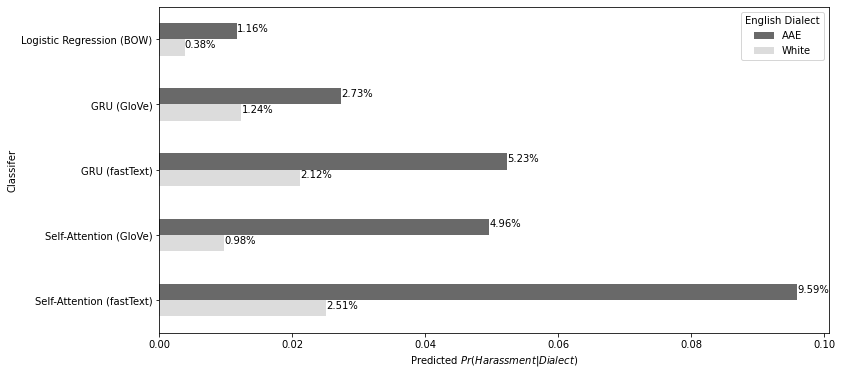

In [ ]:
#Plot Prob(Harassing | AAE) vs Prob(Harassing | White) predictions
fig, axes = plt.subplots(figsize=(12,6))
plot_data3 = pd.concat([plot_data2[0][0].append(plot_data2[1][0]), plot_data2[0][1].append(plot_data2[1][1])], axis=1)
plot_data3 = plot_data3.groupby('variable').apply(lambda x: x/x.sum())
plot_data3.iloc[[1,3,5,7,9]].plot.barh(color=['gainsboro','dimgray'], ax=axes)
handles = axes.get_legend_handles_labels()[0]
axes.legend(handles=reversed(handles), labels=['AAE','White'], loc='upper right', title='English Dialect')
axes.set_yticklabels(models)
axes.set_ylabel('Classifer')
axes.set_xlabel('Predicted $Pr(Harassment|Dialect)$');
for rect in axes.patches:
    label = str(round(100*rect.get_width(),2))+'%'
    axes.text(x = rect.get_width(), y = rect.get_y() + rect.get_height() / 2, s = label)
fig.savefig('racial_diffs.pdf', bbox_inches='tight')